# Deep Bayesian Active Learning with Image Data

This is an implementation of the paper Deep Bayesian Active Learning with Image Data using keras and modAL. [modAL](https://modal-python.readthedocs.io/en/latest/) is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

## Active Learning

In this notebook, we are concerned with pool-based Active Learning. In this setting, we have a large amount of unlabelled data and a small initial labelled training set and we want to choose what data should be labelled next.

To do so, there are several query strategies. In this notebook, we will be using uncertainty sampling: the data chosen to be annotated is the one that maximizes an uncertainty criterion (entropy, gini index, variation ratios ...). 

## Dropout-Based Bayesian Deep Neural Networks

In this Notebook, we will select the data from the unlabelled pool that maximizes the uncertainty of our model. But the model we will be using will be a Bayesian Deep Neural Network. 

Unlike Traditional Deep Learning, where we are looking for the set of weights that maximizes the likelihood of the data (MLE), in bayesian deep learning we are looking for the posterior distribution over the weights and the prediction is then obtained by marginalizing out the weights. As a result, Bayesian models are less prone to overfitting. But unfortunately for big deep models, the posterior distribution is intractable, and we need approximations. 

In 2015, [Gal and Ghahramani](https://arxiv.org/pdf/1506.02142.pdf) showed that deep models with dropout layers can be viewed as a lightweight bayesian approximation. The prior and posterior distributions are simply Bernoulli distributions (0 or the learned value). And the predictions can be cheaply obtained at test time by performing Monte Carlo integrations with dropout layers activated.

So in a nutshell, Dropout-based Bayesian Neural Nets are simply Neural Nets with Dropout layers activated at test time.

In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
def create_keras_model():
    model = Sequential()
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

### create the classifier

In [3]:
classifier = KerasClassifier(create_keras_model)

### read training data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### preprocessing

In [5]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### initial labelled data
We initialize the labelled set with 20 balanced randomly sampled examples

In [6]:
initial_idx = np.array([],dtype=np.int)
for i in range(10):
    idx = np.random.choice(np.where(y_train[:,i]==1)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

### initial unlabelled pool

In [7]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Query Strategies

### Uniform
All the acquisition function we will use will be compared to the uniform acquisition function $\mathbb{U}_{[0,1]}$ which will be our baseline that we would like to beat.

In [8]:
def uniform(learner, X, n_instances=1):
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

### Entropy
Our first acquisition function is the entropy:
$$ \mathbb{H} = - \sum_{c} p_c \log(p_c)$$
where $p_c$ is the probability predicted for class c. This is approximated by:
\begin{align}
p_c &= \frac{1}{T} \sum_t p_{c}^{(t)} 
\end{align}
where $p_{c}^{t}$ is the probability predicted for class c at the t th feedforward pass.

In [9]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(X.shape[0], 2000, replace=False)
    MC_output = K.function([learner.estimator.model.layers[0].input, K.learning_phase()],
                           [learner.estimator.model.layers[-1].output])
    learning_phase = True
    MC_samples = [MC_output([X[random_subset], learning_phase])[0] for _ in range(T)]
    MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]
    expected_p = np.mean(MC_samples, axis=0)
    acquisition = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

### Variation Ratio
the Variation ratio is computed according to:
\begin{align}

\end{align}

In [10]:
def var_ratio(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(X.shape[0], 2000, replace=False)
    MC_output = K.function([learner.estimator.model.layers[0].input, K.learning_phase()],
                           [learner.estimator.model.layers[-1].output])
    learning_phase = True
    MC_samples = [MC_output([X[random_subset], learning_phase])[0] for _ in range(T)]
    MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]
    preds = np.argmax(a, axis=2)
    mode, count = stats.mode(preds, axis=0)
    acquisition = (1 - count / preds.shape[1]).reshape((-1,))
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

In [11]:
def bald(learner, X, n_instances, T=100):
    random_subset = np.random.choice(X.shape[0], 2000, replace=False)
    MC_output = K.function([learner.estimator.model.layers[0].input, K.learning_phase()],
                           [learner.estimator.model.layers[-1].output])
    learning_phase = True
    MC_samples = [MC_output([X[random_subset], learning_phase])[0] for _ in range(T)]
    MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    acquisition = entropy_expected_p - expected_entropy
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

### Active Learning Procedure

In [12]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              epochs=50,
                              batch_size=128,
                              n_queries=100,
                              n_instances=10,
                              verbose=0):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                            verbose=verbose
                           )
    perf_hist = [learner.score(X_test, y_test, verbose=verbose)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx], epochs=epochs, batch_size=batch_size, verbose=verbose)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test, verbose=0)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [15]:
estimator = KerasClassifier(create_keras_model)
entropy_perf_hist = active_learning_procedure(max_entropy,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)
np.save("keras_max_entropy.npy", entropy_perf_hist)

Accuracy after query 1: 0.4677
Accuracy after query 2: 0.5179
Accuracy after query 3: 0.5606
Accuracy after query 4: 0.6541
Accuracy after query 5: 0.7245
Accuracy after query 6: 0.6952
Accuracy after query 7: 0.7183
Accuracy after query 8: 0.7759
Accuracy after query 9: 0.8066
Accuracy after query 10: 0.7511
Accuracy after query 11: 0.7592
Accuracy after query 12: 0.8494
Accuracy after query 13: 0.8656
Accuracy after query 14: 0.8788
Accuracy after query 15: 0.8816
Accuracy after query 16: 0.8990
Accuracy after query 17: 0.8869
Accuracy after query 18: 0.9089
Accuracy after query 19: 0.9076
Accuracy after query 20: 0.9043
Accuracy after query 21: 0.9105
Accuracy after query 22: 0.9178
Accuracy after query 23: 0.9241
Accuracy after query 24: 0.9256
Accuracy after query 25: 0.9323
Accuracy after query 26: 0.9269
Accuracy after query 27: 0.9366
Accuracy after query 28: 0.9346
Accuracy after query 29: 0.9413
Accuracy after query 30: 0.9458
Accuracy after query 31: 0.9458
Accuracy after qu

In [13]:
estimator = KerasClassifier(create_keras_model)
bald_perf_hist = active_learning_procedure(bald,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
np.save("keras_bald.npy", bald_perf_hist)

Accuracy after query 1: 0.5112
Accuracy after query 2: 0.5954
Accuracy after query 3: 0.6834
Accuracy after query 4: 0.7142
Accuracy after query 5: 0.7049
Accuracy after query 6: 0.7340
Accuracy after query 7: 0.7587
Accuracy after query 8: 0.7455
Accuracy after query 9: 0.7708
Accuracy after query 10: 0.7817
Accuracy after query 11: 0.7489
Accuracy after query 12: 0.7904
Accuracy after query 13: 0.8282
Accuracy after query 14: 0.8180
Accuracy after query 15: 0.8261
Accuracy after query 16: 0.8081
Accuracy after query 17: 0.8337
Accuracy after query 18: 0.8178
Accuracy after query 19: 0.8248
Accuracy after query 20: 0.8833
Accuracy after query 21: 0.8728
Accuracy after query 22: 0.8513
Accuracy after query 23: 0.8529
Accuracy after query 24: 0.8573
Accuracy after query 25: 0.8674
Accuracy after query 26: 0.8378
Accuracy after query 27: 0.8805
Accuracy after query 28: 0.8695
Accuracy after query 29: 0.8752
Accuracy after query 30: 0.9010
Accuracy after query 31: 0.8991
Accuracy after qu

In [ ]:
estimator = KerasClassifier(create_keras_model)
var_ratio_perf_hist = active_learning_procedure(var_ratio,
                                               X_test,
                                               y_test,
                                               X_pool,
                                               y_pool,
                                               X_initial,
                                               y_initial,
                                               estimator,)
np.save("keras_bald.npy", bald_perf_hist)

In [13]:
estimator = KerasClassifier(create_keras_model)
uniform_perf_hist = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)
np.save("keras_uniform.npy", uniform_perf_hist)

Accuracy after query 1: 0.6060
Accuracy after query 2: 0.6537
Accuracy after query 3: 0.7004
Accuracy after query 4: 0.7308
Accuracy after query 5: 0.7513
Accuracy after query 6: 0.7800
Accuracy after query 7: 0.7850
Accuracy after query 8: 0.7974
Accuracy after query 9: 0.8412
Accuracy after query 10: 0.8440
Accuracy after query 11: 0.8126
Accuracy after query 12: 0.8447
Accuracy after query 13: 0.8616
Accuracy after query 14: 0.8714
Accuracy after query 15: 0.8841
Accuracy after query 16: 0.8793
Accuracy after query 17: 0.8703
Accuracy after query 18: 0.8725
Accuracy after query 19: 0.8834
Accuracy after query 20: 0.8881
Accuracy after query 21: 0.8805
Accuracy after query 22: 0.8885
Accuracy after query 23: 0.9013
Accuracy after query 24: 0.9102
Accuracy after query 25: 0.9053
Accuracy after query 26: 0.8989
Accuracy after query 27: 0.9087
Accuracy after query 28: 0.9083
Accuracy after query 29: 0.9118
Accuracy after query 30: 0.9123
Accuracy after query 31: 0.9150
Accuracy after qu

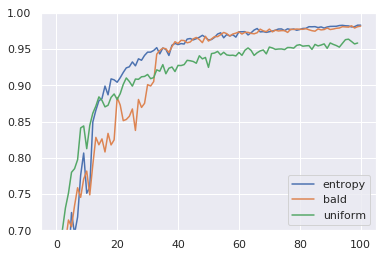

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(entropy_perf_hist, label="entropy")
plt.plot(bald_perf_hist, label="bald")
plt.plot(uniform_perf_hist, label="uniform")
plt.ylim([0.7,1])
plt.legend()